# KNN - BINARY CLASSIFICATION (finale)

In [112]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [113]:
train_df = pd.read_csv("pp_train.csv")
test_df = pd.read_csv("pp_test.csv")

copy_train = train_df.copy()
copy_test = test_df.copy()

In [114]:
copy_train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

#### Deleting outliers

In [115]:
copy_train = copy_train[copy_train["outlier_w_type"] != True]
copy_test = copy_test[copy_test["outlier_w_type"] != True]

#### Creation of the target variable

In [116]:
copy_train['has_lowEngagement'] = (copy_train['numVotes'] < 100).astype(int)
copy_test['has_lowEngagement'] = (copy_test['numVotes'] < 100).astype(int)

In [117]:
x = sum(copy_train["has_lowEngagement"] == 1)
x

10287

#### Selection of the target variable

In [118]:
y_train = np.array(copy_train['has_lowEngagement'])  # Il target originale
y_test = np.array(copy_test["has_lowEngagement"])

In [119]:
title_type_dummies_tr = pd.get_dummies(copy_train['titleType'], prefix='titleType')
title_type_dummies_ts = pd.get_dummies(copy_test['titleType'], prefix='titleType')

copy_train = pd.concat([copy_train, title_type_dummies_tr], axis=1)
copy_test = pd.concat([copy_test, title_type_dummies_ts], axis=1)

#### Feature selection

In [120]:
features = [
        'startYear', 

        'totalNominations', 
        'totalMedia', 
        'totalCredits', 
        'criticReviewsTotal',  #>>> sembrava problematica ma tenuta comunque
        'canHaveEpisodes', 
        'numRegions', 
        #'userReviewsTotal', >>> da togliere perchè troppo simile a numVotes 

        'fill_runtimeMinutes_Bruno',

        'countryOfOrigin_freq_enc',

    #    'countryOfOrigin_NA', 'countryOfOrigin_AF',
    #    'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC',
    #    'countryOfOrigin_SA', 'countryOfOrigin_UNK',
    
        'titleType_movie', 'titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries',
        'titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvSpecial', 'titleType_video',

        "rating",

        'is_Documentary','is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation',
]

# Variabili da log trasformare
log_transform_cols = [ 
    
    'totalNominations', 
    'totalMedia', 
    'totalCredits', 
    'criticReviewsTotal', 
    'numRegions',
    #'userReviewsTotal', >>> da togliere perchè troppo simile a numVotes 
]

# Variabili da scalare
scale_cols = [
        'titleType_movie', 'titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries',
        'titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvSpecial', 'titleType_video', #1he dei titleType

        "rating", 'startYear',  'countryOfOrigin_freq_enc', 'fill_runtimeMinutes_Bruno', #no log-transformed

         
        'totalNominations', 
        'totalMedia', 
        'totalCredits', 'criticReviewsTotal', 
        'numRegions', #numeriche log-transformate

       'is_Documentary','is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', #1he dei generi

    #    'countryOfOrigin_NA', 'countryOfOrigin_AF',
    #    'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC',
    #    'countryOfOrigin_SA', 'countryOfOrigin_UNK',
]

# --- Preprocessing ---
X_train_temp = copy_train[features].copy()
X_test_temp = copy_test[features].copy()

# Log-transform
X_train_temp[log_transform_cols] = np.log1p(X_train_temp[log_transform_cols])
X_test_temp[log_transform_cols] = np.log1p(X_test_temp[log_transform_cols])

# Scaling (fit only on train)
scaler = StandardScaler()
X_train_temp[scale_cols] = scaler.fit_transform(X_train_temp[scale_cols])
X_test_temp[scale_cols] = scaler.transform(X_test_temp[scale_cols]) 


# --- Divisione in train e validation ---
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_temp, y_train, test_size=0.2, random_state=42
)

#### Computation of the proper k

In [121]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

def optimize_knn_with_external_validation(X_train, y_train, X_val, y_val, n_iter=100, cv=5, verbose=1):
    # Calcolo range k
    sqrt_n = int(np.sqrt(X_train.shape[0]))
    
    param_distributions = {
        "n_neighbors": np.arange(1, sqrt_n + 1),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "cityblock"]
    }
    
    random_search = RandomizedSearchCV(
        KNeighborsClassifier(),
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        n_jobs=-1,
        refit=True,
        random_state=42,
        verbose=verbose,
        scoring='accuracy',
        return_train_score=True
    )

    # Fit solo sul training set
    random_search.fit(X_train, y_train)
#
    # Valutazione su validation set
    best_model = random_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Mostra le top 5 configurazioni (sulla cross-validation)
    results = random_search.cv_results_
    sorted_idx = np.argsort(results['rank_test_score'])
    print("\nTop 5 configurations (CV scores):")
    for i in range(5):
        idx = sorted_idx[i]
        print(f"Rank {i+1}: {results['params'][idx]}")
        print(f"   CV Test score: {results['mean_test_score'][idx]:.4f}")
        print(f"   CV Train score: {results['mean_train_score'][idx]:.4f}")

    print(f"\nValidation Accuracy of Best Model: {val_accuracy:.4f}")

    return best_model, random_search.best_params_, val_accuracy

In [122]:
# # best_knn, best_params, best_score = optimize_knn(X_train2_standardsc, y_train2)

# best_knn, best_params, val_score = optimize_knn_with_external_validation(
#     X_train_final, y_train_final, X_val_final, y_val_final)


# # # # Create a new classifier with the optimized parameters
# clf = KNeighborsClassifier(**best_params)
# clf.fit(X_train_final, y_train_final)

# y_pred = clf.predict(X_val_final)

#### Training the model 

In [123]:
clf = KNeighborsClassifier(weights='uniform', n_neighbors=14, metric='cityblock')
clf.fit(X_train_final, y_train_final)

y_pred = clf.predict(X_val_final)

#### Checking if the model overfits

Performance sul Training set:
Accuracy: 0.8638
F1 Score: 0.8597

Performance sul Validation set:
Accuracy: 0.8335
F1 Score: 0.8283


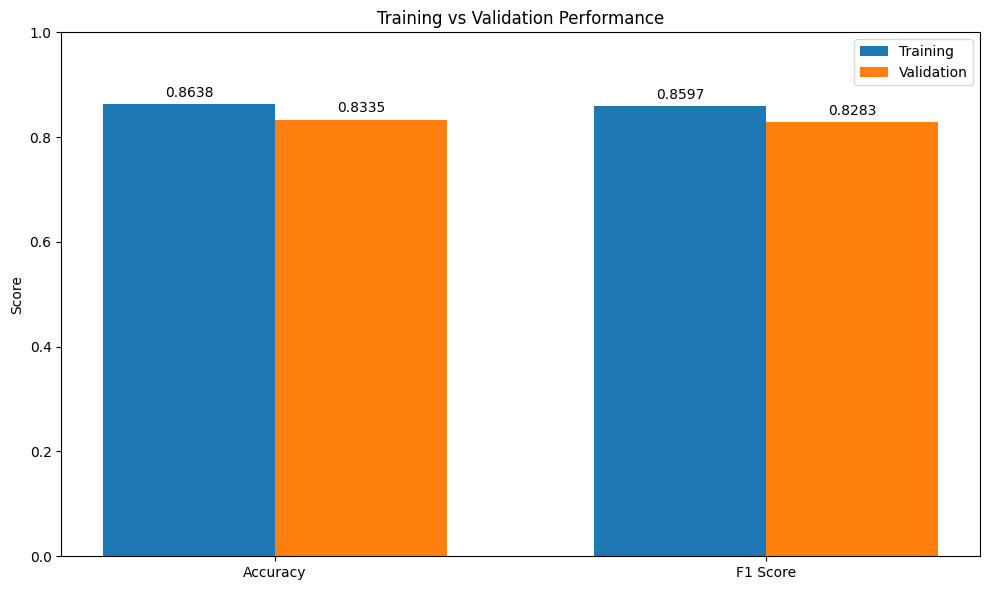

In [124]:
# # Importazioni necessarie (se non già importate)
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_final)
train_accuracy = accuracy_score(y_train_final, y_pred_train)
train_f1 = f1_score(y_train_final, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_final)
val_accuracy = accuracy_score(y_val_final, y_pred_val)
val_f1 = f1_score(y_val_final, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


#### Performance evaluation (validation set)

In [125]:
from sklearn.metrics import classification_report, accuracy_score

class_names = ['high_engagement', 'low_engagement']

# Performance evaluation con nomi semantici
print(f"Validation accuracy: {accuracy_score(y_val_final, y_pred_val)}")
print("\nClassification Report:")
print(classification_report(y_val_final, y_pred_val, target_names=class_names))


Validation accuracy: 0.8335005015045135

Classification Report:
                 precision    recall  f1-score   support

high_engagement       0.79      0.64      0.71       946
 low_engagement       0.85      0.92      0.88      2045

       accuracy                           0.83      2991
      macro avg       0.82      0.78      0.80      2991
   weighted avg       0.83      0.83      0.83      2991



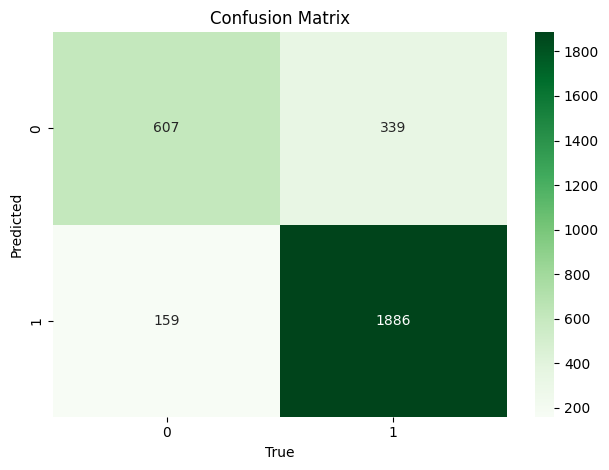

In [126]:
classes_unique = np.unique(y_val_final)
cm = confusion_matrix(y_val_final, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()




plt.show()

#### Training the model (on the x_train_final)

In [127]:
# Inizializza e allena il classificatore KNN
clf = KNeighborsClassifier(weights='uniform', n_neighbors=9, metric='cityblock')
clf.fit(X_train_temp, y_train)

# Predizione sul test set finale
y_pred = clf.predict(X_test_temp) 

Performance sul Training set:
Accuracy: 0.8748
F1 Score: 0.8708

Performance sul Test set:
Accuracy: 0.8335
F1 Score: 0.8283


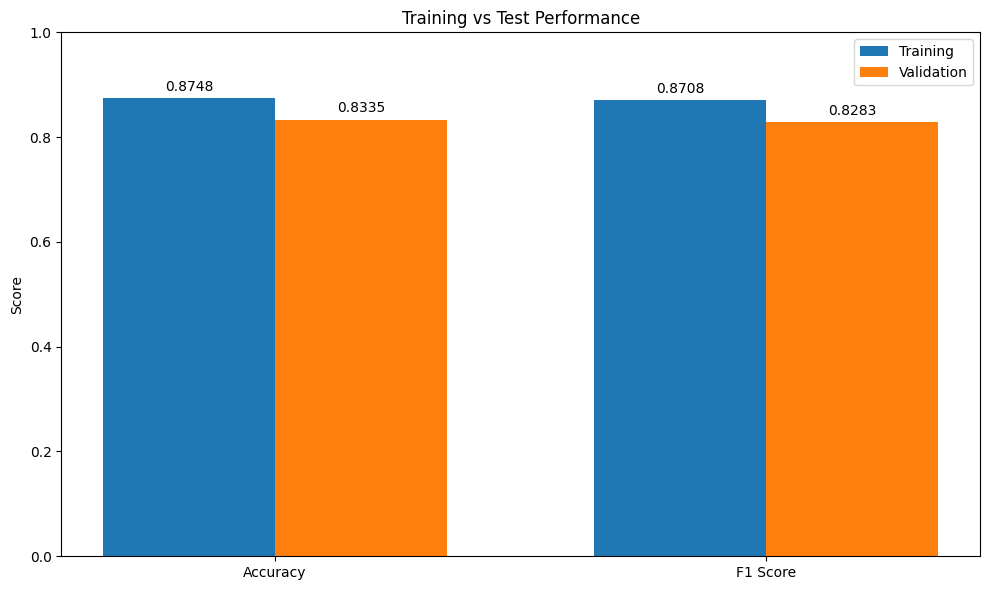

In [128]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_temp)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_temp)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Test set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Performance evaluation (on the test set)

In [129]:
class_names = ['high_engagement', 'low_engagement']

# Performance evaluation con nomi semantici
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Test accuracy: 0.8464938718103275

Classification Report:
                 precision    recall  f1-score   support

high_engagement       0.83      0.65      0.73      1561
 low_engagement       0.85      0.94      0.89      3416

       accuracy                           0.85      4977
      macro avg       0.84      0.79      0.81      4977
   weighted avg       0.84      0.85      0.84      4977



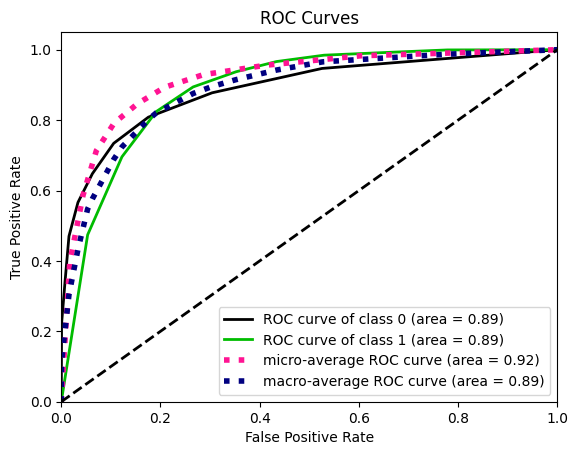

0.8880743781008691


In [130]:
import scikitplot as skplt

# Ottieni le probabilità di tutte le classi
probs = clf.predict_proba(X_test_temp)

# Passa l'intero array di probabilità, non solo una colonna
skplt.metrics.plot_roc(y_test, probs)
plt.show()

# Per il calcolo di AUC, se è binario, puoi usare:
print(roc_auc_score(y_test, probs[:, 1]))

In [ ]:
print("y_test shape:", probs.shape)
print("y_test dtype:", probs.dtype)
print("primi elementi di y_test:", probs[:5])  # Mostra i primi 5 elementi

y_test shape: (4977, 2)
y_test dtype: float64
primi elementi di y_test: [[0.11111111 0.88888889]
 [0.66666667 0.33333333]
 [0.11111111 0.88888889]
 [0.         1.        ]
 [0.22222222 0.77777778]]


In [132]:
import numpy as np
probs = clf.predict_proba(X_test_temp)[:, 1]
np.save('y_true_knn_binary.npy', y_test)
np.save('y_scores_knn_binary.npy', probs)

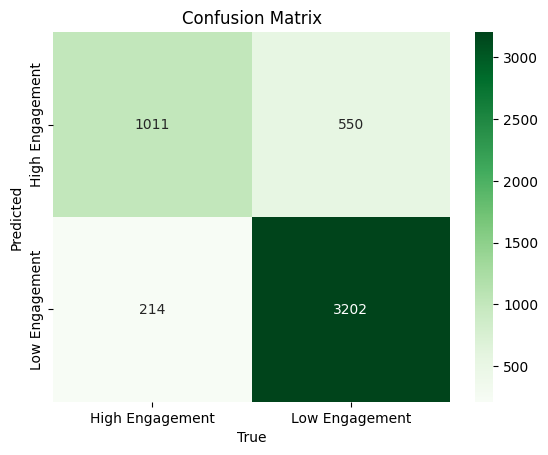

<Figure size 600x600 with 0 Axes>

In [133]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['High Engagement', 'Low Engagement']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=labels, 
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.figure(figsize=(6, 6))
plt.tight_layout()
plt.show()

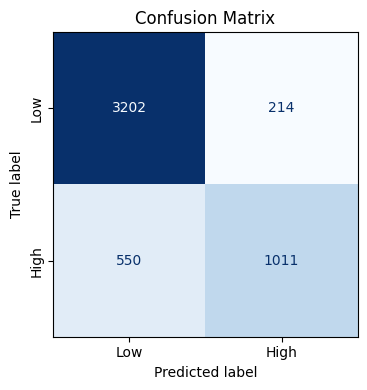

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Mappa delle classi leggibili
label_map = {0: 'High', 1: 'Low'}

# Ordina le classi per frequenza
class_counts = Counter(y_test)
classes = np.array([c for c, _ in class_counts.most_common()])
display_labels = [label_map[c] for c in classes]

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Crea figura e assi
fig, ax = plt.subplots(figsize=(4, 4))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues', colorbar=False, ax=ax)

# Ruota etichette asse x (mantieni orizzontali)
ax.set_xticklabels(display_labels, rotation=0)

# Ruota etichette asse y in orizzontale
ax.set_yticklabels(display_labels, rotation=90, va="center")

# Titolo
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()